In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm
from sklearn.mixture import GaussianMixture


rng = np.random.default_rng()

In [3]:
class SN:
    ia_keys = ['z', 't0', 'x0', 'x1', 'c', 'log_x0']
    ibc_keys = ['z', 'texp', 'mej', 'fni', 'vej', 'log_vej', 'log_fni']
    ia_fit = {key:None for key in ia_keys}
    ibc_fit = {key:None for key in ibc_keys}
    
    def __init__(self, true_class, true_dict):
        self.true_class = true_class
        if self.true_class == 'ia':
            self.true_params = {key:true_dict[key] for key in self.ia_keys}
        elif self.true_class == 'ibc':
            self.true_params = {key:true_dict[key] for key in self.ibc_keys}
        else:
            raise ValueError("SN has to be either ia or ibc")
            
    def fit_as_ia(self, results_dict):
        self.ia_fit = {key:results_dict[key] for key in self.ia_keys[1:]}
    
    def fit_as_ibc(self, results_dict):
        self.ibc_fit = {key:results_dict[key] for key in self.ibc_keys[1:]}
        self.ibc_fit.update({'log_vej': np.log10(self.ibc_fit['vej'])})

In [4]:
class real_SN:
    ia_keys = ['z', 't0', 'x0', 'x1', 'c']
    ibc_keys = ['z', 'texp', 'mej', 'fni', 'vej']
    ia_fit = {key:None for key in ia_keys}
    ibc_fit = {key:None for key in ibc_keys}
    
    def __init__(self, true_class, true_redshift):
        self.true_class = true_class
        self.true_redshift = true_redshift
        # if self.true_class == 'ia':
        #     self.true_params = {key:true_dict[key] for key in self.ia_keys}
        # elif self.true_class == 'ibc':
        #     self.true_params = {key:true_dict[key] for key in self.ibc_keys}
        # else:
        #     raise ValueError("SN has to be either ia or ibc")
            
    def fit_as_ia(self, results_dict):
        self.ia_fit = {key:results_dict[key] for key in self.ia_keys[1:]}
    
    def fit_as_ibc(self, results_dict):
        self.ibc_fit = {key:results_dict[key] for key in self.ibc_keys[1:]}

In [5]:
data = np.load("fitted_sne_real_011526.npz", allow_pickle=True)

true_ia_sne = data['ia']
true_ibc_sne = data['ibc']
all_sne = np.concatenate((true_ia_sne, true_ibc_sne))
len(true_ibc_sne), len(all_sne), len(true_ia_sne)/len(all_sne)


(251, 497, 0.4949698189134809)

In [6]:
for sn in all_sne:
    sn.ibc_fit.update({'log_vej': np.log10(sn.ibc_fit['vej'])})
    sn.ia_fit.update({'log_x0': np.log10(sn.ia_fit['x0'])})
    sn.ibc_fit.update({'log_fni': np.log10(sn.ibc_fit['fni'])})

In [7]:
all_sne[100].true_class

'SN Ia'

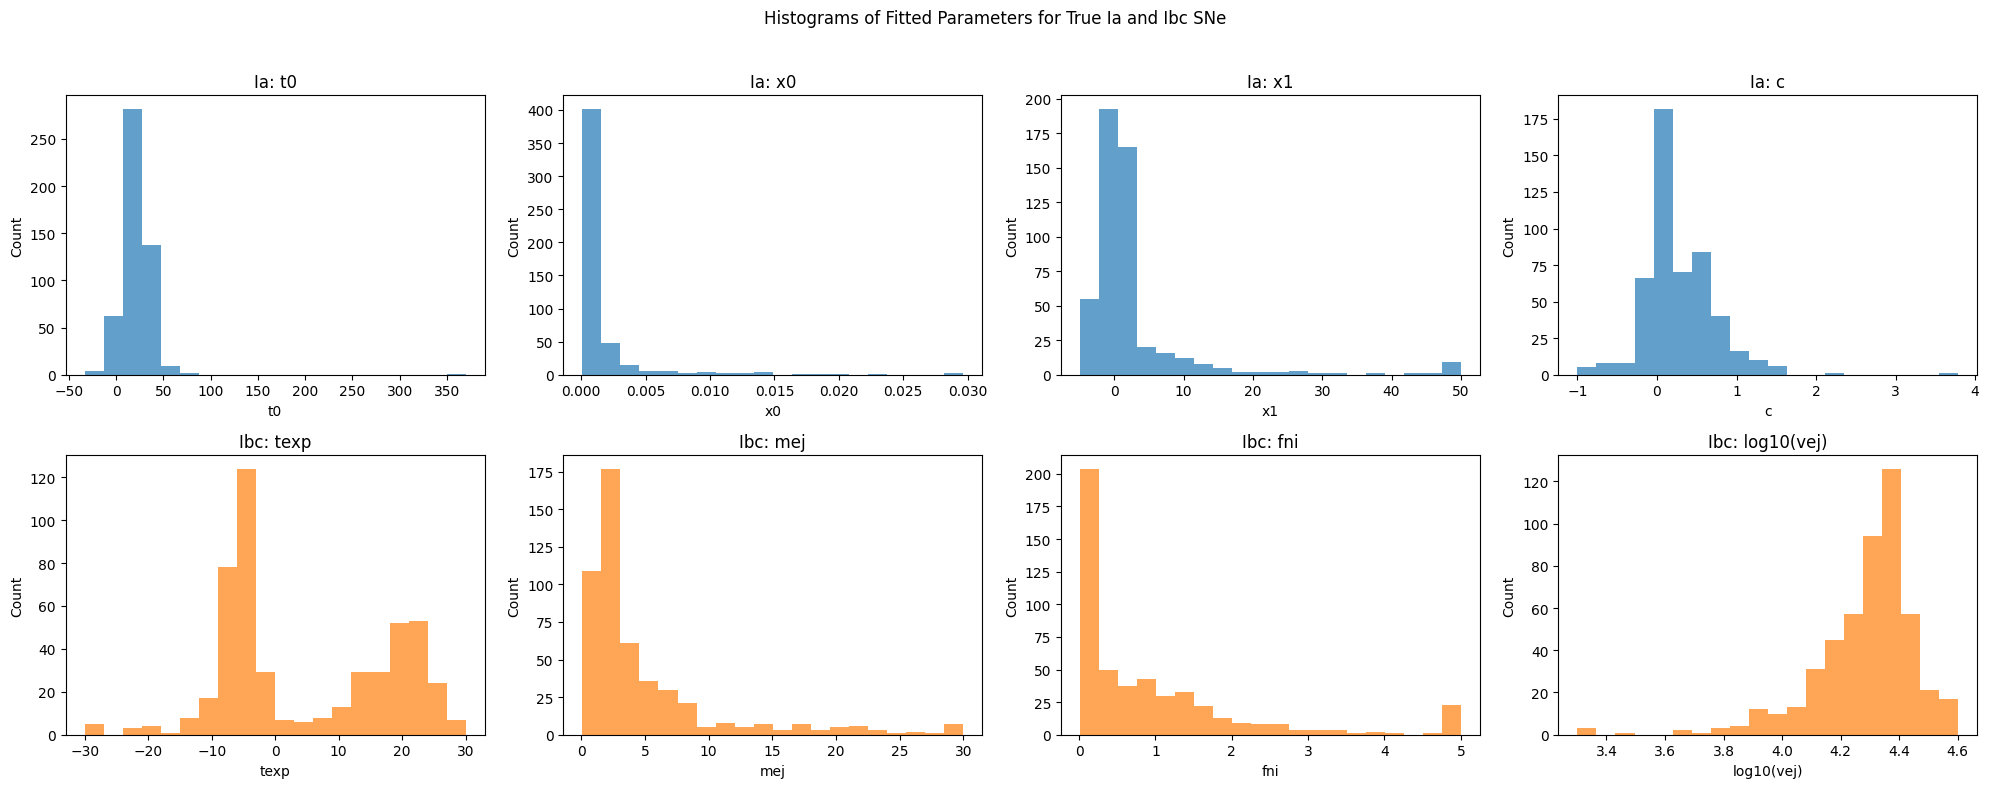

In [8]:
ia_param_names = SN.ia_keys[1:]  # ['t0', 'x0', 'x1', 'c']
ibc_param_names = SN.ibc_keys[1:]  # ['texp', 'mej', 'fni', 'vej']

fig, axes = plt.subplots(2, 4, figsize=(20, 8))
fig.suptitle("Histograms of Fitted Parameters for True Ia and Ibc SNe")

# Plot Ia fitted parameters
for i, param in enumerate(ia_param_names[:4]):
    values = [sn.ia_fit[param] for sn in all_sne if sn.ia_fit[param] is not None]
    axes[0, i].hist(values, bins=20, color='tab:blue', alpha=0.7)
    axes[0, i].set_title(f"Ia: {param}")
    axes[0, i].set_xlabel(param)
    axes[0, i].set_ylabel("Count")

# Plot Ibc fitted parameters
for i, param in enumerate(ibc_param_names[:4]):
    values = [sn.ibc_fit[param] for sn in all_sne if sn.ibc_fit[param] is not None]
    if param == 'vej':
        # Plot log10 for vej
        values = [np.log10(v) for v in values if v > 0]
        axes[1, i].hist(values, bins=20, color='tab:orange', alpha=0.7)
        axes[1, i].set_title(f"Ibc: log10({param})")
        axes[1, i].set_xlabel(f"log10({param})")
    else:
        axes[1, i].hist(values, bins=20, color='tab:orange', alpha=0.7)
        axes[1, i].set_title(f"Ibc: {param}")
        axes[1, i].set_xlabel(param)
    axes[1, i].set_ylabel("Count")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

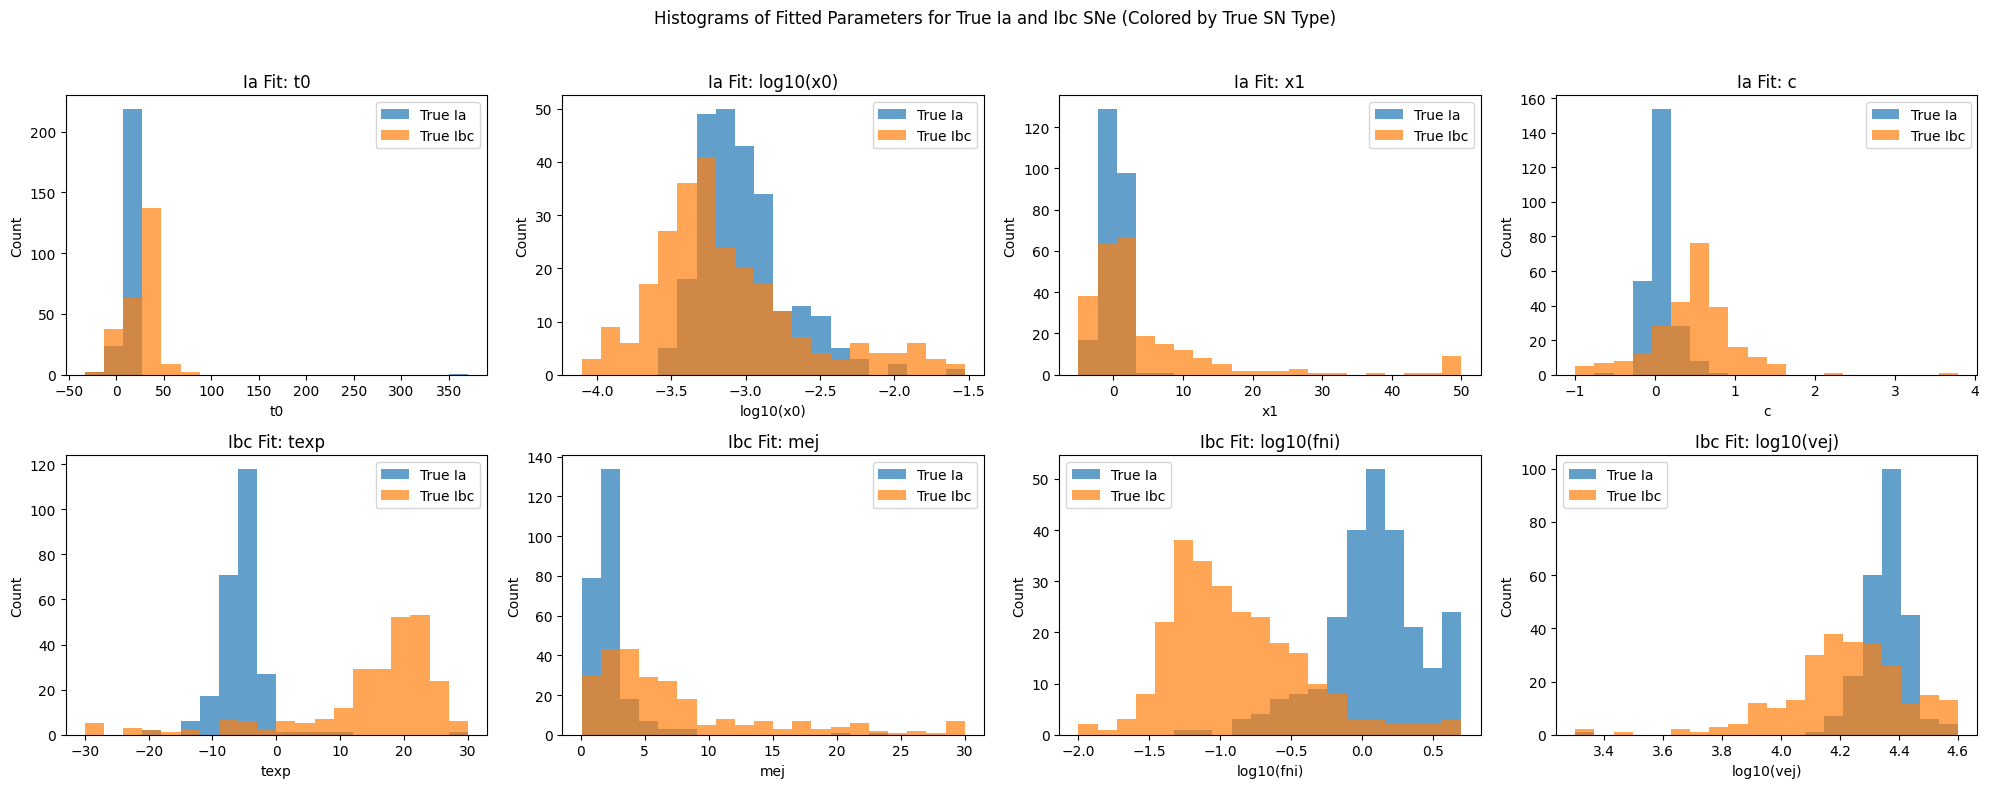

In [9]:
fig, axes = plt.subplots(2, 4, figsize=(20, 8))
fig.suptitle("Histograms of Fitted Parameters for True Ia and Ibc SNe (Colored by True SN Type)")

# Plot Ia fitted parameters
for i, param in enumerate(ia_param_names[:4]):
    ia_values = [sn.ia_fit[param] for sn in true_ia_sne if sn.ia_fit[param] is not None]
    ibc_values = [sn.ia_fit[param] for sn in true_ibc_sne if sn.ia_fit[param] is not None]
    if param == 'x0':
        ia_values = [np.log10(v) for v in ia_values if v > 0]
        ibc_values = [np.log10(v) for v in ibc_values if v > 0]
    all_values = ia_values + ibc_values
    bins = np.histogram_bin_edges(all_values, bins=20)
    axes[0, i].hist(ia_values, bins=bins, color='tab:blue', alpha=0.7, label='True Ia')
    axes[0, i].hist(ibc_values, bins=bins, color='tab:orange', alpha=0.7, label='True Ibc')
    if param == 'x0':
        axes[0, i].set_title(f"Ia Fit: log10({param})")
        axes[0, i].set_xlabel(f"log10({param})")
    else:
        axes[0, i].set_title(f"Ia Fit: {param}")
        axes[0, i].set_xlabel(param)
    axes[0, i].set_ylabel("Count")
    axes[0, i].legend()

# Plot Ibc fitted parameters
for i, param in enumerate(ibc_param_names[:4]):
    ia_values = [sn.ibc_fit[param] for sn in true_ia_sne if sn.ibc_fit[param] is not None]
    ibc_values = [sn.ibc_fit[param] for sn in true_ibc_sne if sn.ibc_fit[param] is not None]
    if param == 'vej' or param == 'fni':
        ia_values = [np.log10(v) for v in ia_values if v > 0]
        ibc_values = [np.log10(v) for v in ibc_values if v > 0]
    all_values = ia_values + ibc_values
    bins = np.histogram_bin_edges(all_values, bins=20)
    axes[1, i].hist(ia_values, bins=bins, color='tab:blue', alpha=0.7, label='True Ia')
    axes[1, i].hist(ibc_values, bins=bins, color='tab:orange', alpha=0.7, label='True Ibc')
    if param == 'vej' or param == 'fni':
        axes[1, i].set_title(f"Ibc Fit: log10({param})")
        axes[1, i].set_xlabel(f"log10({param})")
    else:
        axes[1, i].set_title(f"Ibc Fit: {param}")
        axes[1, i].set_xlabel(param)
    axes[1, i].set_ylabel("Count")
    axes[1, i].legend()

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Here we have 8 parameters that we can use to constrain the mixing fraction

In [10]:
# This is the log likelihood function for the distribution of one parameter 
# assuming a mixture of two Gaussians.
# x is the parameter value, samples are the observed data, and alpha is the mixing fraction
def log_likelihood(x, samples, alpha):
    mu1, sigma1, mu2, sigma2 = x
    first_term = alpha * norm.pdf(samples, mu1, sigma1)
    second_term = (1 - alpha) * norm.pdf(samples, mu2, sigma2)
    return np.sum(np.log(first_term + second_term))

In [11]:
def get_param_samples(param_name):
    if param_name in ia_param_names:
        return np.array([sn.ia_fit[param_name] for sn in all_sne])
    elif param_name in ibc_param_names:
        return np.array([sn.ibc_fit[param_name] for sn in all_sne])
    else:
        raise ValueError(f"Parameter {param_name} not recognized in either Ia or Ibc SNe.")

(array([450.,  21.,   8.,   6.,   6.,   1.,   2.,   1.,   0.,   2.]),
 array([7.88257576e-05, 3.03767383e-03, 5.99652190e-03, 8.95536997e-03,
        1.19142180e-02, 1.48730661e-02, 1.78319142e-02, 2.07907623e-02,
        2.37496103e-02, 2.67084584e-02, 2.96673065e-02]),
 <BarContainer object of 10 artists>)

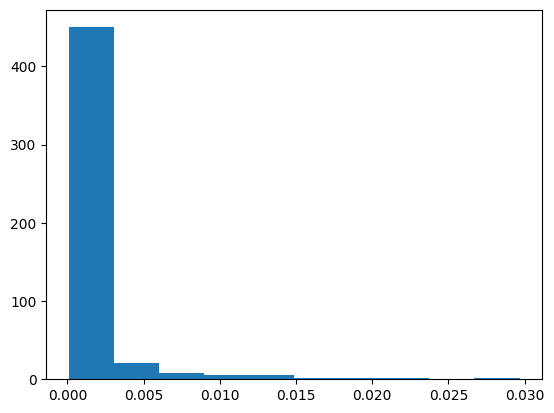

In [12]:
plt.hist(get_param_samples('x0'))

In [13]:
np.shape(get_param_samples('log_vej').reshape(-1, 1))

(497, 1)

In [14]:
# Fit initial guesses
params_to_use = ['t0', 'c', 'mej', 'texp', 'x1', 'log_x0', 'log_fni', 'log_vej']

mus_a = {}
mus_b = {}
sigmas_a = {}
sigmas_b = {}

for param_name in params_to_use:
    # samples = get_param_samples(param_name).reshape(-1, 1)
    # gm = GaussianMixture(n_components=2).fit(samples)
    # mus_a[param_name] = gm.means_[0][0]
    # mus_b[param_name] = gm.means_[1][0]
    # sigmas_a[param_name] = np.sqrt(gm.covariances_[0][0][0])
    # sigmas_b[param_name] = np.sqrt(gm.covariances_[1][0][0])
    # print(param_name, gm.weights_, sigmas_a[param_name], sigmas_b[param_name])
    mus_a[param_name] = np.median(get_param_samples(param_name)) - np.std(get_param_samples(param_name))
    mus_b[param_name] = np.median(get_param_samples(param_name)) + np.std(get_param_samples(param_name))
    sigmas_a[param_name] = np.std(get_param_samples(param_name))
    sigmas_b[param_name] = np.std(get_param_samples(param_name))

In [15]:
# from sklearn.mixture import GaussianMixture

gm = GaussianMixture(n_components=2).fit(get_param_samples('x1').reshape(-1, 1))
gm.means_, gm.covariances_**0.5, gm.weights_

(array([[ 0.01640678],
        [16.04564736]]),
 array([[[ 1.83002494]],
 
        [[15.49217402]]]),
 array([0.8409466, 0.1590534]))

In [16]:
num_epochs = 200
lls = np.zeros(num_epochs)


# mus_a = {'t0': 20, 'x0': 0.0001, 'x1': 2, 'c': 0, 'texp': 0.5, 'mej': 8, 'fni': 0.05, 'log_vej': 4.3}
# mus_b = {'t0': 20, 'x0': 0.0001, 'x1': 0.5, 'c': 0.6, 'texp': 5, 'mej': 2, 'fni': 0.49, 'log_vej': 3.9}
# sigmas_a = {'t0': 10, 'x0': 5e-4, 'x1': 0.01, 'c': 0.1, 'texp': 0.2, 'mej': 2, 'fni': 0.01, 'log_vej': 0.05}
# sigmas_b = {'t0': 10, 'x0': 5e-4, 'x1': 1, 'c': 0.3, 'texp': 3, 'mej': 2, 'fni': 5e-2, 'log_vej': 0.2}


alphas = np.zeros(num_epochs)  # Store alpha values for each epoch
alpha = 0.5  # Mixing fraction
gammas_a = {'texp': [], 'mej': [], 'log_fni': [], 'log_vej': [], 't0': [], 'log_x0': [], 'x1': [], 'c': []}
gammas_b = {'texp': [], 'mej': [], 'log_fni': [], 'log_vej': [], 't0': [], 'log_x0': [], 'x1': [], 'c': []}

params_to_use = ['t0', 'c', 'mej', 'texp', 'x1', 'log_x0', 'log_fni', 'log_vej']
# params_to_use = list(mus_a.keys())  # Use all parameters for fitting



# there are two populations, a and b
for epoch in range(num_epochs):
    # for param_name in list(mus_a.keys())[:3]:
    for param_name in params_to_use:
        param_samples = get_param_samples(param_name)

        # plt.hist(param_samples)
        # plt.show()

        # print(mus_a[param_name], sigmas_a[param_name])
        # the gammas are weights for every sample
        gammas_a[param_name] = alpha * norm.pdf(param_samples, mus_a[param_name], sigmas_a[param_name])
        gammas_b[param_name] = (1 - alpha) * norm.pdf(param_samples, mus_b[param_name], sigmas_b[param_name])
        
        # print(param_name)
        # print(np.sum(gammas_a[param_name]), np.sum(gammas_b[param_name]))
        # print(sum(np.isnan(gammas_a[param_name])), sum(np.isinf(gammas_a[param_name])))

        # Normalize over parameter
        gamma_total = (gammas_a[param_name] + gammas_b[param_name])
        gammas_a[param_name] /= gamma_total
        gammas_b[param_name] /= gamma_total
        

        mus_a[param_name] = np.sum(gammas_a[param_name] * param_samples) / np.sum(gammas_a[param_name])
        mus_b[param_name] = np.sum(gammas_b[param_name] * param_samples) / np.sum(gammas_b[param_name])
        sigmas_a[param_name] = np.sqrt(np.sum(gammas_a[param_name] * (param_samples - mus_a[param_name])**2) / np.sum(gammas_a[param_name]))
        sigmas_b[param_name] = np.sqrt(np.sum(gammas_b[param_name] * (param_samples - mus_b[param_name])**2) / np.sum(gammas_b[param_name]))

        if sigmas_a[param_name] < 0.001:
            sigmas_a[param_name] = 0.001
        if sigmas_b[param_name] < 0.001:
            sigmas_b[param_name] = 0.001

    
    # Here we can use information from all parameters to constrain the mixing fraction
    # alpha is the fraction of parameter a, parameter b has 1 - alpha
    alpha = np.mean(np.concatenate([gammas_a[param_name] for param_name in params_to_use]))
    alphas[epoch] = alpha
    print("Alpha", alpha)

    # Calculate log likelihood for the current epoch
    for param_name in params_to_use:
        lls[epoch] += log_likelihood([mus_a[param_name], sigmas_a[param_name], mus_b[param_name], sigmas_b[param_name]], get_param_samples(param_name), alpha)

    

Alpha 0.45630818907877607
Alpha 0.5062518160648031
Alpha 0.5394617061553613
Alpha 0.5576187035990087
Alpha 0.5647190458712745
Alpha 0.565872294205618
Alpha 0.5647432180706781
Alpha 0.5630367341644781
Alpha 0.5613127876935173
Alpha 0.5596961835249378
Alpha 0.558179658466075
Alpha 0.5567294624103675
Alpha 0.5553178066581189
Alpha 0.5539309310578012
Alpha 0.5525693416970372
Alpha 0.5512451433029552
Alpha 0.5499777997272717
Alpha 0.5487890917721181
Alpha 0.5476982804581886
Alpha 0.5467185196067424
Alpha 0.5458552287511916
Alpha 0.545106502002903
Alpha 0.5444649191789277
Alpha 0.5439198073972299
Alpha 0.5434592158310667
Alpha 0.5430712937034149
Alpha 0.5427450837044403
Alpha 0.5424708798501867
Alpha 0.5422403114784783
Alpha 0.5420462780790773
Alpha 0.541882816115575
Alpha 0.541744944855572
Alpha 0.5416285156909404
Alpha 0.5415300760287969
Alpha 0.5414467514822815
Alpha 0.5413761463769448
Alpha 0.5413162609209541
Alpha 0.5412654228042918
Alpha 0.5412222309465919
Alpha 0.5411855093079077
Alph

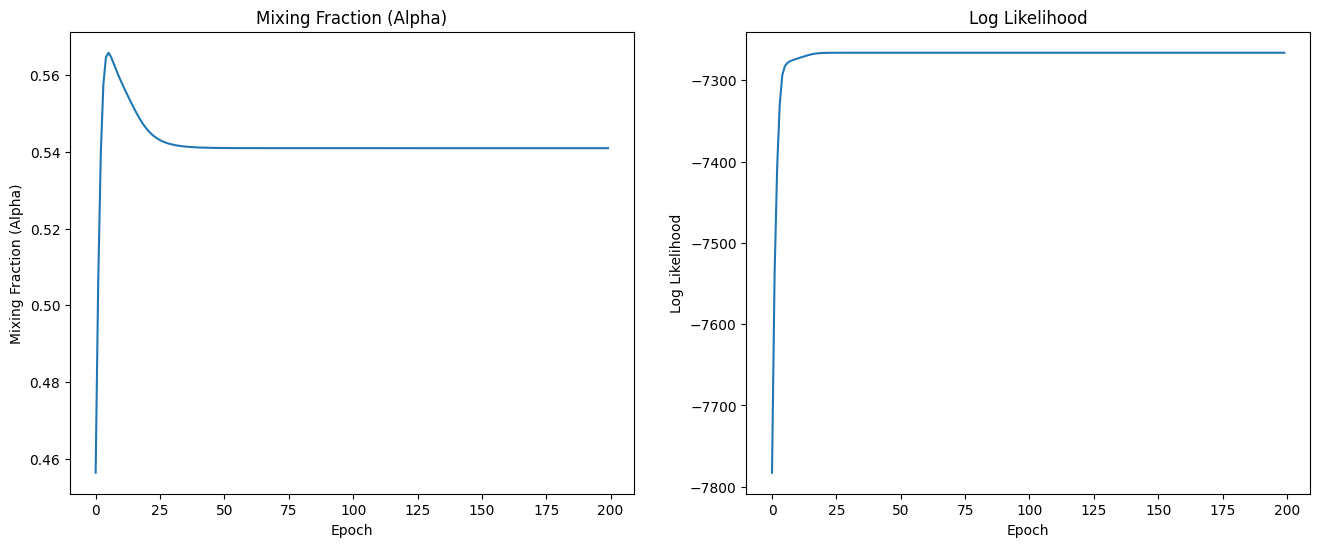

In [17]:
fig, ax = plt.subplots(1,2, figsize=(16, 6))
ax[0].plot(alphas)
ax[1].plot(lls)
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Mixing Fraction (Alpha)")
ax[0].set_title("Mixing Fraction (Alpha)")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Log Likelihood")
ax[1].set_title("Log Likelihood")

plt.show()

In [18]:
prob_a = np.ones(len(all_sne))

for i in range(len(all_sne)):
    s = 0
    b = 0
    for param in params_to_use:
        s += gammas_a[param][i]
        b += gammas_b[param][i]
    prob_a[i] = s / (s + b)

(array([  7.,  25.,  29.,  52.,  67.,  44.,  50.,  62., 131.,  30.]),
 array([0.17495756, 0.23503355, 0.29510954, 0.35518554, 0.41526153,
        0.47533752, 0.53541351, 0.59548951, 0.6555655 , 0.71564149,
        0.77571748]),
 <BarContainer object of 10 artists>)

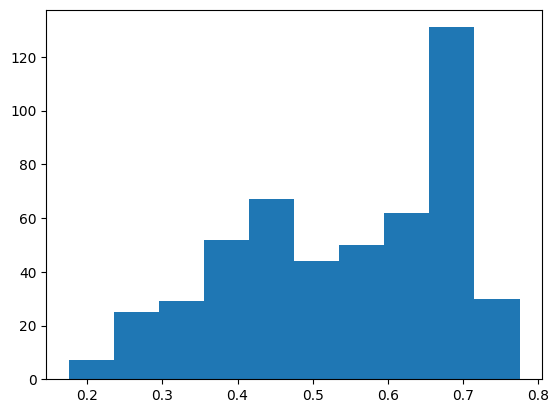

In [19]:
plt.hist(prob_a)

In [20]:
classifications = ['SN Ia' if p >= 0.5 else 'SN Ibc' for p in prob_a]
true_classes = [sn.true_class for sn in all_sne]
# true_classes

In [21]:
num_correct_ia = 0
num_correct_ibc = 0
num_wrong_true_ia = 0
num_wrong_true_ibc = 0


for a,b in zip(true_classes, classifications):
    if a == 'SN Ia':
        if b == 'SN Ia':
            num_correct_ia += 1
        else:
            num_wrong_true_ia += 1
    else:
        if b == 'SN Ibc':
            num_correct_ibc += 1
        else:
            num_wrong_true_ibc += 1

print(num_correct_ia, num_correct_ibc, num_wrong_true_ia, num_wrong_true_ibc)
print((num_correct_ia + num_correct_ibc) / len(all_sne))

234 189 12 62
0.8511066398390342


In [22]:
classifications_rough = np.ones(len(all_sne))
for i in range(len(all_sne)):
    probs = np.array([gammas_a[param][i] for param in params_to_use])
    num_a = sum(probs >= 0.5)
    if num_a >= 4:
        classifications_rough[i] = 0
classifications_rough = ['SN Ia' if i == 0 else 'SN Ibc' for i in classifications_rough]


In [23]:
num_correct_ia = 0
num_correct_ibc = 0
num_wrong_true_ia = 0
num_wrong_true_ibc = 0


for a,b in zip(true_classes, classifications_rough):
    if a == 'SN Ia':
        if b == 'SN Ia':
            num_correct_ia += 1
        else:
            num_wrong_true_ia += 1
    else:
        if b == 'SN Ibc':
            num_correct_ibc += 1
        else:
            num_wrong_true_ibc += 1

print(num_correct_ia, num_correct_ibc, num_wrong_true_ia, num_wrong_true_ibc)
print((num_correct_ia + num_correct_ibc) / len(all_sne))

240 105 6 146
0.6941649899396378


In [24]:
mus_a, mus_b, sigmas_a, sigmas_b

({'t0': 11.494535693683162,
  'c': 0.03539403312403024,
  'mej': 2.0768607524054485,
  'texp': -5.466955556091328,
  'x1': 0.10735326647935582,
  'log_x0': -3.1955592093856695,
  'log_fni': -0.9441967573406607,
  'log_vej': 4.2241574787415885},
 {'t0': 28.506528824868518,
  'c': 0.46656372268470325,
  'mej': 9.469403178746528,
  'texp': 13.188620441039628,
  'x1': 8.437553095263862,
  'log_x0': -2.929236014510158,
  'log_fni': 0.14216777421114252,
  'log_vej': 4.357106280523816},
 {'t0': 3.012498081363664,
  'c': 0.10772409532189633,
  'mej': 1.039502483547076,
  'texp': 2.1358306059347423,
  'x1': 1.4036113944026363,
  'log_x0': 0.20533908788213362,
  'log_fni': 0.38057804131934553,
  'log_vej': 0.22025537515811544},
 {'t0': 29.02900180569128,
  'c': 0.5158143876256628,
  'mej': 7.290984583078516,
  'texp': 12.969240352490072,
  'x1': 14.202494116415744,
  'log_x0': 0.5487370679138455,
  'log_fni': 0.29466746037184083,
  'log_vej': 0.0591320902686213})

In [25]:
# for n in sigmas_b.keys():
#     if sigmas_b[n] <= 0.01:
#         sigmas_b[n] = 0.01

# for n in sigmas_a.keys():
#     if sigmas_a[n] <= 0.01:
#         sigmas_a[n] = 0.01

In [26]:
# sigmas_a['x0'] = 1e-5
# sigmas_b['x0'] = 1e-6

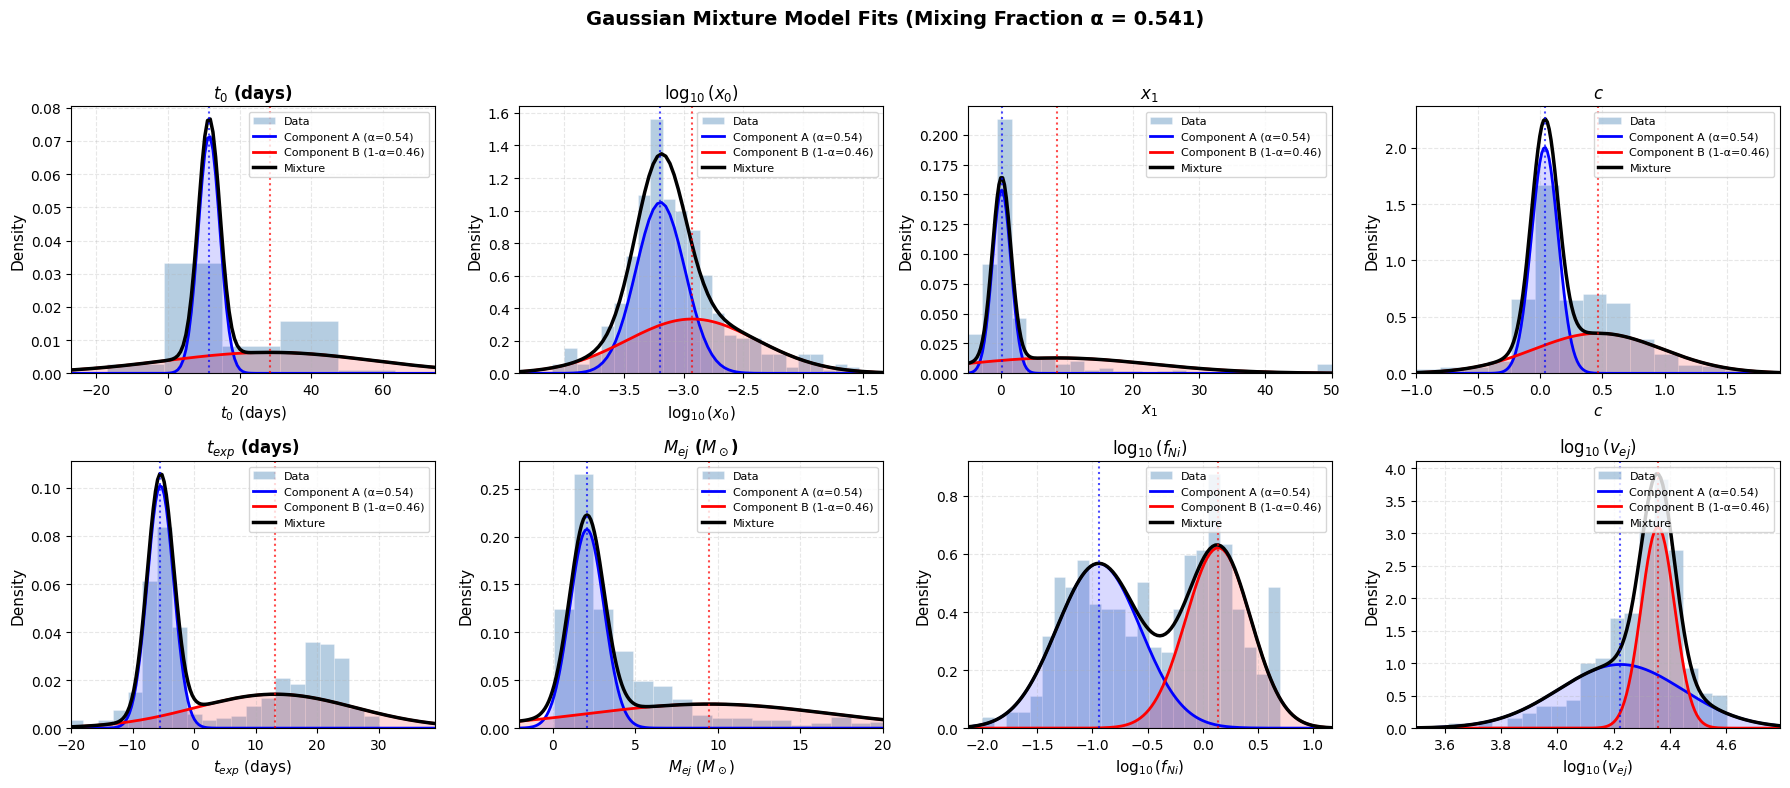


Fitted Gaussian Mixture Parameters:
----------------------------------------------------------------------
Parameter           μ_A        σ_A        μ_B        σ_B
----------------------------------------------------------------------
t0              11.4945     3.0125    28.5065    29.0290
log_x0          -3.1956     0.2053    -2.9292     0.5487
x1               0.1074     1.4036     8.4376    14.2025
c                0.0354     0.1077     0.4666     0.5158
texp            -5.4670     2.1358    13.1886    12.9692
mej              2.0769     1.0395     9.4694     7.2910
log_fni         -0.9442     0.3806     0.1422     0.2947
log_vej          4.2242     0.2203     4.3571     0.0591


In [28]:
# Define x ranges for plotting
x_ranges = {
    't0': np.linspace(-50, 100, 200),
    'log_x0': np.linspace(-6, 1, 200),
    'x1': np.linspace(-5, 50, 200),
    'c': np.linspace(-1, 2, 200),
    'texp': np.linspace(-20, 50, 200),
    'mej': np.linspace(-2, 20, 200),
    'log_fni': np.linspace(-3, 2, 200),
    'log_vej': np.linspace(3.5, 5, 200)
}

# Parameter display names
param_labels = {
    't0': r'$t_0$ (days)',
    'log_x0': r'$\log_{10}(x_0)$',
    'x1': r'$x_1$',
    'c': r'$c$',
    'texp': r'$t_{exp}$ (days)',
    'mej': r'$M_{ej}$ ($M_\odot$)',
    'log_fni': r'$\log_{10}(f_{Ni})$',
    'log_vej': r'$\log_{10}(v_{ej})$'
}

# Create figure with better styling
fig, axes = plt.subplots(2, 4, figsize=(18, 8))
fig.suptitle(f"Gaussian Mixture Model Fits (Mixing Fraction α = {alpha:.3f})", fontsize=14, fontweight='bold')

params_plot = ['t0', 'log_x0', 'x1', 'c', 'texp', 'mej', 'log_fni', 'log_vej']

for idx, param in enumerate(params_plot):
    ax = axes.flat[idx]
    
    # Get samples and set up parameters
    samples = get_param_samples(param)
    mu_a, mu_b = mus_a[param], mus_b[param]
    sigma_a, sigma_b = sigmas_a[param], sigmas_b[param]

    x = x_ranges[param]
    
    # Plot histogram with better styling
    n, bins, patches = ax.hist(samples, bins=25, density=True, alpha=0.4, 
                                color='steelblue', edgecolor='white', linewidth=0.5,
                                label='Data')
    
    # Compute mixture components
    y_a = alpha * norm.pdf(x, mu_a, sigma_a)
    y_b = (1 - alpha) * norm.pdf(x, mu_b, sigma_b)
    y_mix = y_a + y_b
    
    # Plot components with better styling
    ax.plot(x, y_a, 'b-', linewidth=2, label=f'Component A (α={alpha:.2f})')
    ax.plot(x, y_b, 'r-', linewidth=2, label=f'Component B (1-α={1-alpha:.2f})')
    ax.plot(x, y_mix, 'k-', linewidth=2.5, label='Mixture')
    
    # Fill under curves for visibility
    ax.fill_between(x, y_a, alpha=0.15, color='blue')
    ax.fill_between(x, y_b, alpha=0.15, color='red')
    
    # Set axis limits based on data
    data_min, data_max = np.percentile(samples, [1, 99])
    x_margin = (data_max - data_min) * 0.2
    ax.set_xlim(max(x[0], data_min - x_margin), min(x[-1], data_max + x_margin))
    
    # Styling
    ax.set_xlabel(param_labels[param], fontsize=11)
    ax.set_ylabel('Density', fontsize=11)
    ax.set_title(param_labels[param], fontsize=12, fontweight='bold')
    ax.legend(fontsize=8, loc='upper right')
    ax.grid(True, alpha=0.3, linestyle='--')
    
    # Add mean markers
    ax.axvline(mu_a, color='blue', linestyle=':', alpha=0.7, linewidth=1.5)
    ax.axvline(mu_b, color='red', linestyle=':', alpha=0.7, linewidth=1.5)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Print summary statistics
print("\nFitted Gaussian Mixture Parameters:")
print("-" * 70)
print(f"{'Parameter':<12} {'μ_A':>10} {'σ_A':>10} {'μ_B':>10} {'σ_B':>10}")
print("-" * 70)
for param in params_plot:
        print(f"{param:<12} {mus_a[param]:>10.4f} {sigmas_a[param]:>10.4f} {mus_b[param]:>10.4f} {sigmas_b[param]:>10.4f}")